In [124]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # visuals 

from sklearn.preprocessing import MinMaxScaler # scale the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # time series Generator
from tensorflow.keras.models import Sequential # Sequential model
from tensorflow.keras.layers import Dense, LSTM, Dropout # LSTM
from tensorflow.keras.callbacks import EarlyStopping # Early Stopping
import tensorflow as tf
# load the dataset
df = pd.read_csv('sales_forcasting.csv', parse_dates = True, index_col='DATE')
dataset = df.values
dataset = dataset.astype('float32')


In [125]:
df.head()

,item_sold
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfaa5e9e50>],
      dtype=object)

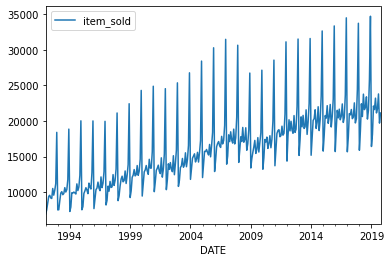

In [126]:
df.plot(subplots=True)

In [127]:
df.head()

,item_sold
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


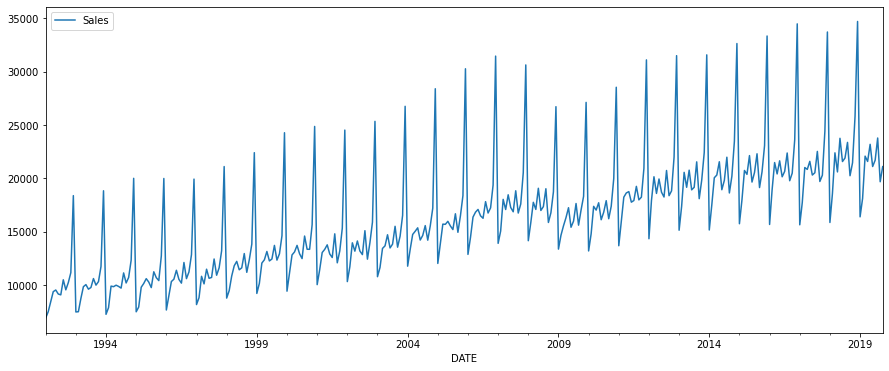

In [128]:
# scaler 
# rename the column
df.columns = ['Sales']
# plot the data 
df.plot(figsize = (15,6));

In [129]:
# rename the column
df.columns = ['Sales']

In [130]:
# train test split 
test_size = 18
test_index = len(df) - test_size 

train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [131]:
train.tail()

,Sales
DATE,
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616


In [132]:
test.head()

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260


In [133]:
# scaler 
scaler = MinMaxScaler()

# fit the scaler on the training data 
scaler.fit(train)

# use the scaler to transform training and test data 
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [134]:
# Timeseries Generator
length = 12 # a whole year 
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size = 1)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size = 1)

In [135]:
X, y = train_generator[0]

In [136]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [137]:
y

array([[0.02047633]])

In [138]:
from tensorflow import keras
reconstructed_model = keras.models.load_model("trained_model.h5")

In [139]:
# number of features in our dataset
n_features = 1 
reconstructed_model = keras.models.load_model("trained_model.h5")


# compile the model
reconstructed_model.compile(optimizer='adam', loss = 'mse')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# fir the model
history = reconstructed_model.fit(train_generator, validation_data= validation_generator, callbacks = [early_stop]);

304/304 [==============================] - 4s 7ms/step - loss: 0.0014 - val_loss: 2.6321e-04


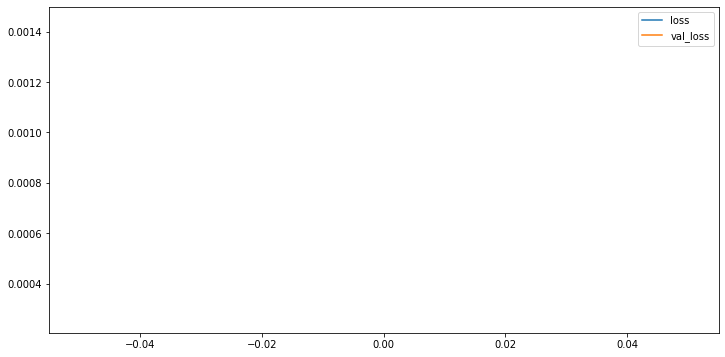

In [140]:
# plot losses 
losses = pd.DataFrame(reconstructed_model.history.history)
losses.plot(figsize = (12,6))

In [141]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = reconstructed_model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [142]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [143]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,21118.500319
2018-06-01,21589,20025.920395
2018-07-01,21919,20261.923648
2018-08-01,23381,22052.436265
2018-09-01,20260,19655.011234
2018-10-01,21473,20290.756067
2018-11-01,25831,24153.906246
2018-12-01,34706,33397.597635
2019-01-01,16410,15929.796814


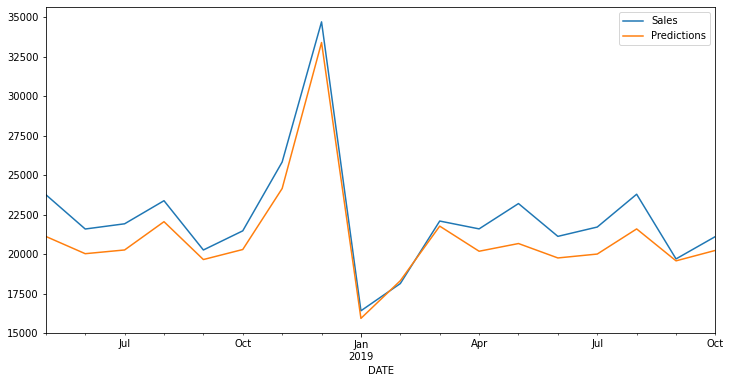

In [144]:
test.plot(figsize = (12, 6));

In [145]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = reconstructed_model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [146]:
# true values of the forcast  
forecast = scaler.inverse_transform(forecast)

In [147]:
# create a date index 
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [148]:
# concatinate index with forcasts  
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])
forecast_df

,Forecast
2019-11-01,25416.405687
2019-12-01,34284.284007
2020-01-01,16302.577571
2020-02-01,17948.677724
2020-03-01,21440.679046
2020-04-01,21033.769584
2020-05-01,22500.844251
2020-06-01,20631.194342
2020-07-01,21205.082948
2020-08-01,23119.081458


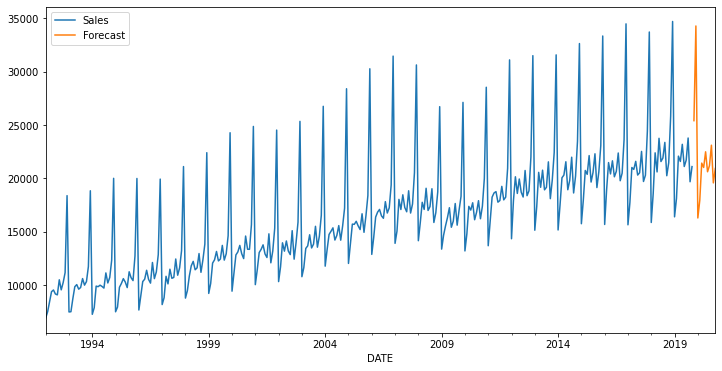

In [149]:
ax = df.plot(figsize = (12,6))
forecast_df.plot(ax = ax)

(576.0, 611.0)

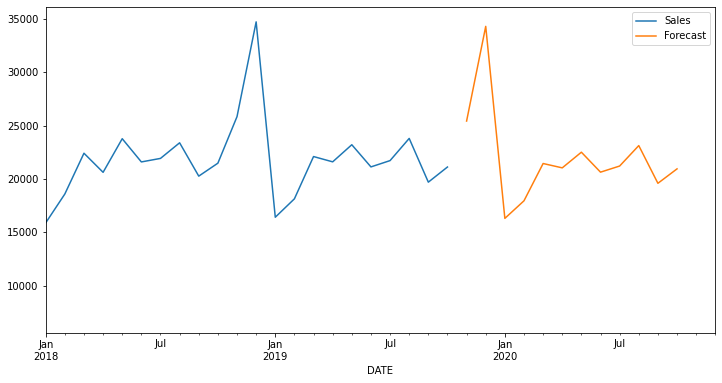

In [150]:
# zoom in
ax = df.plot(figsize = (12,6))
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')